In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


# Data exploration
In here i tried to re-organize the data to a ['message','label'] shape for better readability

In [2]:
data =  pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv',encoding="ISO-8859-1")
data['label'] = data['v1']
data['message'] = data['v2']
data = data[['message','label']]
# the garbage collector will take care of the columns v1 and v2 ;)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  5572 non-null   object
 1   label    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


# Vectorization
Now  - since we have textual data - we have to vectorize the messages to render them usable by ML models <br>
There are few methods to vectorize the data such as : <br>
**Bag of Words** : the simplest technique , A Dictionnary of Counts of each word in data<br>
**TF-IDF** : We can think of it as Weighted Bag of Words , (reduce weight of common words across data , increase the weight of rare words)<br>
**n-grams** : A different approach which considers the importance of sequences rather than just individual words which lead to better contextualization<br>

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

#with n-grams
# vectorizer  = TfidfVectorizer(ngram_range=(1,3))

#without n-grams
vectorizer  = TfidfVectorizer()


label_encoder = LabelEncoder()



X  = vectorizer.fit_transform(data['message'])
Y  = label_encoder.fit_transform(data['label'])

Y


array([0, 0, 1, ..., 0, 0, 0])

In [4]:
!pip install xgboost

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train , X_test, y_train,  y_test = train_test_split(X,Y,test_size=0.2,random_state=1)

/tmp/ipykernel_32/1286019924.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


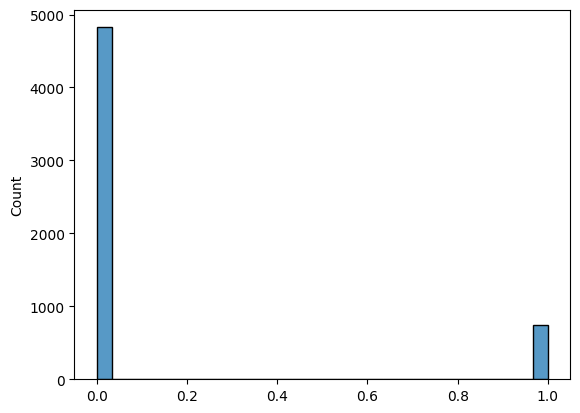

In [10]:
with pd.option_context('mode.use_inf_as_na', True):
    sns.histplot(Y, bins=30)
    plt.show()

In [7]:
len(Y[Y==0])

4825

In [8]:
len(Y[Y==1])

747

# Imbalanced Data : 
The data seems to be imbalanced and that requires intervention to help the model actually learn and catch the difference in classes rather than just ignore 'them'. luckily there are many techniques that help (such as oversampling )

In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()


old_X_train , old_y_train = X_train , y_train
X_train, y_train = smote.fit_resample(X_train, y_train)


Notice that we only upsample the training data , and that is because upsampling the test dta will skew the model metrics 

In [10]:

from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=1*1000).fit(X_train, y_train)
predicted_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)
score = clf.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
cs_report = classification_report(y_test,y_pred)

print(f"Accuracy : {accuracy:.2f}")
print('Classification Report :\n',cs_report)



Accuracy : 0.99
Classification Report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       976
           1       0.99      0.94      0.97       139

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [11]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cs_report = classification_report(y_test,y_pred)
print(f"Accuracy : {accuracy:.2f}")
print('Classification Report :\n',cs_report)

Accuracy : 0.99
Classification Report :
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       976
           1       0.96      0.93      0.94       139

    accuracy                           0.99      1115
   macro avg       0.97      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=200, random_state=0)
clf.fit(X_train,y_train)
predicted_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)
score = clf.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
cs_report = classification_report(y_test,y_pred)

print(f"Accuracy : {accuracy:.2f}")
print('Classification Report :\n',cs_report)

Accuracy : 0.99
Classification Report :
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       976
           1       1.00      0.91      0.95       139

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [13]:
from sklearn.ensemble import GradientBoostingClassifier


clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,
    max_depth=50, random_state=0)
clf.fit(X_train,y_train)
predicted_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)
score = clf.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
cs_report = classification_report(y_test,y_pred)

print(f"Accuracy : {accuracy:.2f}")
print('Classification Report :\n',cs_report)

Accuracy : 0.97
Classification Report :
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       976
           1       0.85      0.94      0.89       139

    accuracy                           0.97      1115
   macro avg       0.92      0.96      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [14]:
from sklearn.svm import SVC



X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


svm_model = SVC(kernel='linear')  
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cs_report = classification_report(y_test, y_pred)

print(f"Accuracy : {accuracy:.2f}")
print("Classification Report:\n", cs_report)


Accuracy : 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.86      0.92       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [15]:
svm_model = SVC(kernel='rbf')  
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cs_report = classification_report(y_test, y_pred)

print(f"Accuracy : {accuracy:.2f}")
print("Classification Report:\n", cs_report)

Accuracy : 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       1.00      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.95      1115
weighted avg       0.98      0.98      0.98      1115

